In [1]:
import numpy as np
import pylab as pl
import random
import matplotlib.pyplot as plt

# Problem 1: Gillespies algorithm

In [89]:
def sir_event(initial,time, params, noise=False): 
    """We asumme inital conditions as integers and X,Y,Z ordered"""
    gamma, beta, mu = params[0], params[1], params[2]
    rates = np.zeros(6)
    N = sum(initial)
    initial = np.array(initial)
    rates[0] = mu*N  #Birth
    rates[1] = beta*initial[0]*initial[1]/N #Tranmission
    rates[2] = gamma*initial[1] #
    rates[3] = mu*initial[0]
    rates[4] = mu*initial[1]
    rates[5] = mu*initial[2]
    changes = np.array([[1,0,0],[-1, 1, 0], [0,-1, 1], [-1, 0, 0], [0, -1, 0], [0, 0 ,-1]])
    dtm = [-np.log(np.random.rand())/rate for rate in rates]
    indx = np.argmin(dtm)
    dt = dtm[indx]
    event = np.array([initial + changes[indx]]).T
    return event, time + dt


def event_loop(tmax, initial, function, arguments):
    '''Keeps loop for '''
    time = [0]
    results = np.array([[value] for value in initial])
    while time[-1] < tmax:
        event, tn = function(initial, time[-1], arguments)
        results = np.concatenate((results, event), axis= 1)
        initial = event[:,0]
        time.append(tn)
    time = np.array(time)
    return time, results

C:\Users\Aleks\AppData\Local\Temp\ipykernel_13596\3472942838.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  dtm = [-np.log(np.random.rand())/rate for rate in rates]


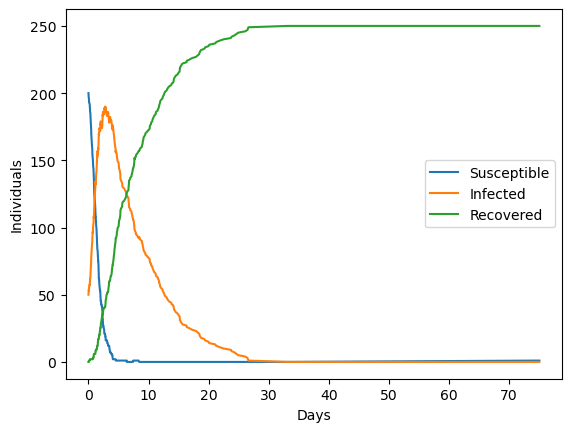

In [26]:

p =  [0.15,1.5,1/(365*60)]
N = 100
populations = 100* np.array([0.85, 0.15, 0])
x, y = event_loop(50, [200,50,0], sir_event,p )

# print(y[0;])
plt.plot(x, y[0,:], label = 'Susceptible')
plt.plot(x, y[1,:], label = 'Infected')
plt.plot(x, y[2,:], label = 'Recovered')

plt.xlabel('Days')
plt.ylabel('Individuals')
plt.legend()


## Investigating simulation variability

In [1]:
'test'

'test'

## Simulation variability and negative covariance

## Stochastic resonance and Increased transients

## Extinction events and critial community size

In [54]:
# Define loop where we stop  when infection reaches extinction
def event_loop2(initial, function, arguments):
    '''Keeps loop for '''
    time = [0]
    results = np.array([[value] for value in initial])
    k = 0 
    while True:
        event, tn = function(initial, time[-1], arguments)
        results = np.concatenate((results, event), axis= 1)
        initial = event[:,0]
        time.append(tn)
        if event[1][0] == 0:
            break
    time = np.array(time)
    return time, results

### Effect of population size N

C:\Users\Aleks\AppData\Local\Temp\ipykernel_13596\3472942838.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  dtm = [-np.log(np.random.rand())/rate for rate in rates]


Text(0, 0.5, 'Average extinction time')

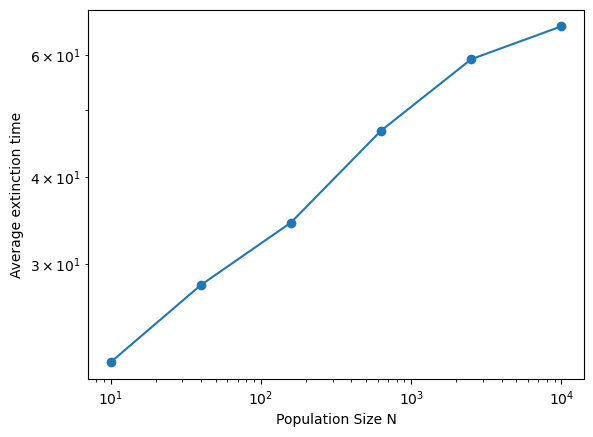

In [99]:
# Run montecarlo simulation with one N and collect values --> Calculate median value per N value
beta = 1.5
gamma = 0.15
mu = 1/(60*365)
np.random.seed(69)

# Running loop for different Ns
Ns = np.logspace(1, 4, 6)
end_times = []

for j in range(len(Ns)):
    N = Ns[j]
    I0 = int(N * (0.25))
    S0 = int(N * 0.75)
    R0 = int(N * 0)
    initial = [S0, I0, R0]
    t = [] 
    print(f"Current N: {N}")
    for k in range(5):
#         print(f"Current k: {k}")
        initial = [S0, I0, R0]
        params = [gamma, beta, mu]
        times, results = event_loop2(initial, sir_event,params)
        t.append(times[-1])
    avg_time = np.average(t)
    end_times.append(avg_time)
    
plt.scatter(Ns, end_times)
plt.plot(Ns, end_times)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Population Size N')
plt.ylabel('Average extinction time')
# Run simulation for differnt N's , Run multiple times and compile all the final times

### Effect of R0

In [ ]:
# Setting random number seed
np.random.seed(69)

# Run montecarlo simulation with one N and collect values --> Calculate median value per N value
gamma = 0.15
mu = 1/(60*365)
betas = np.linspace(1.3,50,10) * gamma

N = 100
I0 = int(N * (0.25))
S0 = int(N * 0.75)
R0 = int(N * 0)

Rp = betas/(gamma + mu)
end_times = []
for j in range(len(Rp)):
    beta = betas[j]
    print(Rp[j])
    params = [gamma, beta, mu]
    t = [] 
    for k in range(5):
        times, results = event_loop2(initial, sir_event,params)
        t.append(times[-1])
    avg_time = np.average(t)
    end_times.append(avg_time)
    
plt.scatter(Rp, end_times)
plt.plot(Rp, end_times)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$R_0$')
plt.ylabel('Average extinction time')

1.2996043822276324


C:\Users\Aleks\AppData\Local\Temp\ipykernel_13596\3472942838.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  dtm = [-np.log(np.random.rand())/rate for rate in rates]


Text(0, 0.5, 'Average extinction time')

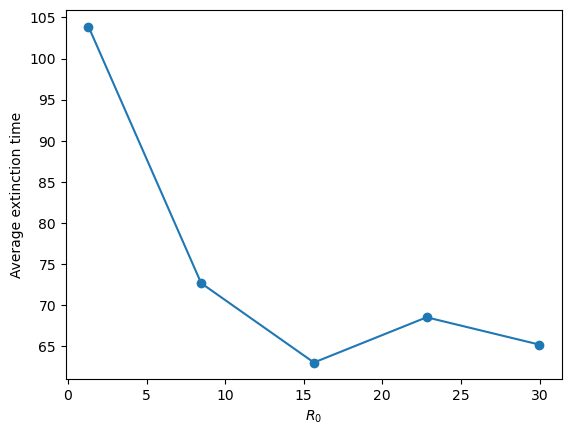

In [122]:
plt.scatter(Rp, end_times)
plt.plot(Rp, end_times)
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel(r'$R_0$')
plt.ylabel('Average extinction time')